# Project 1: Trading with Momentum


### Load Packages

In [1]:
import pandas as pd
import numpy as np
import helper
import project_helper
import project_tests
import matplotlib.pyplot as plt 

## Market Data
### Load Data
The data we use for most of the projects is end of day data. This contains data for many stocks, but we'll be looking at stocks in the S&P 500. We also made things a little easier to run by narrowing down our range of time period instead of using all of the data.

In [2]:
df = pd.read_csv('eod-quotemedia.csv', parse_dates=['date'], index_col=False)

close = df.reset_index().pivot(index='date', columns='ticker', values='adj_close')

print('Loaded Data')

Loaded Data


### View Data
Run the cell below to see what the data looks like for `close`.

In [3]:
project_helper.print_dataframe(close)

### Stock Example
Let's see what a single stock looks like from the closing prices. For this example and future display examples in this project, we'll use Apple's stock (AAPL). If we tried to graph all the stocks, it would be too much information.

In [4]:
apple_ticker = 'AAPL'
project_helper.plot_stock(close[apple_ticker], '{} Stock'.format(apple_ticker))

## Resample Adjusted Prices

The trading signal you'll develop in this project does not need to be based on daily prices, for instance, you can use month-end prices to perform trading once a month. To do this, you must first resample the daily adjusted closing prices into monthly buckets, and select the last observation of each month.

Implement the `resample_prices` to resample `close_prices` at the sampling frequency of `freq`.

In [5]:
def resample_prices(close_prices, freq='M'):
    """
    Resample close prices for each ticker at specified frequency.
    
    Parameters
    ----------
    close_prices : DataFrame
        Close prices for each ticker and date
    freq : str
        What frequency to sample at
        For valid freq choices, see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#offset-aliases
    
    Returns
    -------
    prices_resampled : DataFrame
        Resampled prices for each ticker and date
    """

    
    return close_prices.resample(freq).last()

project_tests.test_resample_prices(resample_prices)

Tests Passed


### View Data
Let's apply this function to `close` and view the results.

In [7]:
monthly_close = resample_prices(close)
project_helper.plot_resampled_prices(
   monthly_close.loc[:, apple_ticker],
  close.loc[:, apple_ticker],
 '{} Stock - Close Vs Monthly Close'.format(apple_ticker))

## Compute Log Returns

Compute log returns ($R_t$) from prices ($P_t$) as your primary momentum indicator:

$$R_t = log_e(P_t) - log_e(P_{t-1})$$

Implement the `compute_log_returns` function below, such that it accepts a dataframe (like one returned by `resample_prices`), and produces a similar dataframe of log returns. Use Numpy's [log function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log.html) to help you calculate the log returns.

In [8]:
def compute_log_returns(prices):
    """
    Compute log returns for each ticker.
    
    Parameters
    ----------
    prices : DataFrame
        Prices for each ticker and date
    
    Returns
    -------
    log_returns : DataFrame
        Log returns for each ticker and date
    """

    
    return np.log(prices) - np.log(prices.shift(1))

project_tests.test_compute_log_returns(compute_log_returns)

Tests Passed


### View Data
Using the same data returned from `resample_prices`, we'll generate the log returns.

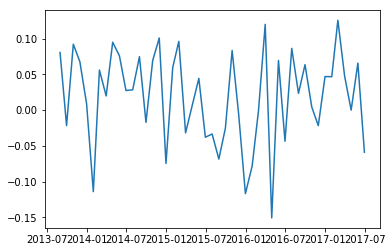

In [10]:
monthly_close_returns = compute_log_returns(monthly_close)
project_helper.plot_returns(
   monthly_close_returns.loc[:, apple_ticker],
    'Log Returns of {} Stock (Monthly)'.format(apple_ticker))

## Shift Returns
Implement the `shift_returns` function to shift the log returns to the previous or future returns in the time series. For example, the parameter `shift_n` is 2 and `returns` is the following:

```
                           Returns
               A         B         C         D
2013-07-08     0.015     0.082     0.096     0.020     ...
2013-07-09     0.037     0.095     0.027     0.063     ...
2013-07-10     0.094     0.001     0.093     0.019     ...
2013-07-11     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...
```

the output of the `shift_returns` function would be:
```
                        Shift Returns
               A         B         C         D
2013-07-08     NaN       NaN       NaN       NaN       ...
2013-07-09     NaN       NaN       NaN       NaN       ...
2013-07-10     0.015     0.082     0.096     0.020     ...
2013-07-11     0.037     0.095     0.027     0.063     ...
...            ...       ...       ...       ...
```
Using the same `returns` data as above, the `shift_returns` function should generate the following with `shift_n` as -2:
```
                        Shift Returns
               A         B         C         D
2013-07-08     0.094     0.001     0.093     0.019     ...
2013-07-09     0.092     0.057     0.069     0.087     ...
...            ...       ...       ...       ...       ...
...            ...       ...       ...       ...       ...
...            NaN       NaN       NaN       NaN       ...
...            NaN       NaN       NaN       NaN       ...
```
_Note: The "..." represents data points we're not showing._

In [11]:
def shift_returns(returns, shift_n):
    """
    Generate shifted returns
    
    Parameters
    ----------
    returns : DataFrame
        Returns for each ticker and date
    shift_n : int
        Number of periods to move, can be positive or negative
    
    Returns
    -------
    shifted_returns : DataFrame
        Shifted returns for each ticker and date
    """    
    return returns.shift(shift_n)

project_tests.test_shift_returns(shift_returns)

Tests Passed


### View Data
Let's get the previous month's and next month's returns.

In [13]:
prev_returns = shift_returns(monthly_close_returns, 1)
lookahead_returns = shift_returns(monthly_close_returns, -1)
project_helper.plot_shifted_returns(
   prev_returns.loc[:, apple_ticker],
  monthly_close_returns.loc[:, apple_ticker],
 'Previous Returns of {} Stock'.format(apple_ticker))
project_helper.plot_shifted_returns(
   lookahead_returns.loc[:, apple_ticker],
  monthly_close_returns.loc[:, apple_ticker],
 'Lookahead Returns of {} Stock'.format(apple_ticker))

## Generate Trading Signal

A trading signal is a sequence of trading actions, or results that can be used to take trading actions. A common form is to produce a "long" and "short" portfolio of stocks on each date (e.g. end of each month, or whatever frequency you desire to trade at). This signal can be interpreted as rebalancing your portfolio on each of those dates, entering long ("buy") and short ("sell") positions as indicated.

Here's a strategy that we will try:
> For each month-end observation period, rank the stocks by _previous_ returns, from the highest to the lowest. Select the top performing stocks for the long portfolio, and the bottom performing stocks for the short portfolio.

Implement the `get_top_n` function to get the top performing stock for each month. Get the top performing stocks from `prev_returns` by assigning them a value of 1. For all other stocks, give them a value of 0. For example, using the following `prev_returns`:

```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0.015     0.082     0.096     0.020     0.075     0.043     0.074
2013-07-09     0.037     0.095     0.027     0.063     0.024     0.086     0.025
...            ...       ...       ...       ...       ...       ...       ...
```

The function `get_top_n` with `top_n` set to 3 should return the following:
```
                                     Previous Returns
               A         B         C         D         E         F         G
2013-07-08     0         1         1         0         1         0         0
2013-07-09     0         1         0         1         0         1         0
...            ...       ...       ...       ...       ...       ...       ...
```
*Note: You may have to use Panda's [`DataFrame.iterrows`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.DataFrame.iterrows.html) with [`Series.nlargest`](https://pandas.pydata.org/pandas-docs/version/0.21/generated/pandas.Series.nlargest.html) in order to implement the function. This is one of those cases where creating a vecorization solution is too difficult.*

In [14]:
def get_top_n(prev_returns, top_n):
    """
    Select the top performing stocks
    
    Parameters
    ----------
    prev_returns : DataFrame
        Previous shifted returns for each ticker and date
    top_n : int
        The number of top performing stocks to get
    
    Returns
    -------
    top_stocks : DataFrame
        Top stocks for each ticker and date marked with a 1
    """
    prev_returns_copy = prev_returns.copy()
    for index,row in prev_returns_copy.iterrows():
        x = prev_returns_copy.loc[index].nlargest(top_n).min()
        if x == float('nan'):
            prev_returns_copy.loc[index] = [0 for i in range(len(row))]            
        else:
            prev_returns_copy.loc[index] = (prev_returns_copy.loc[index] >= float(x)).astype('int64')             
    return prev_returns_copy.astype('int64')

project_tests.test_get_top_n(get_top_n)

Tests Passed


### View Data
We want to get the best performing and worst performing stocks. To get the best performing stocks, we'll use the `get_top_n` function. To get the worst performing stocks, we'll also use the `get_top_n` function. However, we pass in `-1*prev_returns` instead of just `prev_returns`. Multiplying by negative one will flip all the positive returns to negative and negative returns to positive. Thus, it will return the worst performing stocks.

In [15]:
top_bottom_n = 50
df_long = get_top_n(prev_returns, top_bottom_n)
df_short = get_top_n(-1*prev_returns, top_bottom_n)
project_helper.print_top(df_long, 'Longed Stocks')
project_helper.print_top(df_short, 'Shorted Stocks')

10 Most Longed Stocks:
AVGO, DAL, ALK, AMD, AYI, CNC, ATVI, EA, ADSK, AAPL
10 Most Shorted Stocks:
CHK, COG, APA, DVN, CTL, CXO, AAP, AKAM, ANDV, AES


## Projected Returns
It's now time to check if your trading signal has the potential to become profitable!

We'll start by computing the net returns this portfolio would return. For simplicity, we'll assume every stock gets an equal dollar amount of investment. This makes it easier to compute a portfolio's returns as the simple arithmetic average of the individual stock returns.

Implement the `portfolio_returns` function to compute the expected portfolio returns. Using `df_long` to indicate which stocks to long and `df_short` to indicate which stocks to short, calculate the returns using `lookahead_returns`. To help with calculation, we've provided you with `n_stocks` as the number of stocks we're investing in a single period.

In [16]:
def portfolio_returns(df_long, df_short, lookahead_returns, n_stocks):
    """
    Compute expected returns for the portfolio, assuming equal investment in each long/short stock.
    
    Parameters
    ----------
    df_long : DataFrame
        Top stocks for each ticker and date marked with a 1
    df_short : DataFrame
        Bottom stocks for each ticker and date marked with a 1
    lookahead_returns : DataFrame
        Lookahead returns for each ticker and date
    n_stocks: int
        The number number of stocks chosen for each month
    
    Returns
    -------
    portfolio_returns : DataFrame
        Expected portfolio returns for each ticker and date
    """
    signals_long = np.array(df_long)
    signals_short = np.array(df_short)
    returns = np.array(lookahead_returns)
    df = ((df_long - df_short)*lookahead_returns)/n_stocks
    
    return df

project_tests.test_portfolio_returns(portfolio_returns)

Tests Passed


### View Data
Time to see how the portfolio did.

In [19]:
expected_portfolio_returns = portfolio_returns(df_long, df_short, lookahead_returns, 2*top_bottom_n)

project_helper.plot_returns(expected_portfolio_returns.T.sum(), 'Portfolio Returns')

## Statistical Tests
### Annualized Rate of Return

In [20]:
expected_portfolio_returns_by_date = expected_portfolio_returns.T.sum().dropna()
portfolio_ret_mean = expected_portfolio_returns_by_date.mean()
portfolio_ret_ste = expected_portfolio_returns_by_date.sem()
portfolio_ret_annual_rate = (np.exp(portfolio_ret_mean * 12) - 1) * 100

print("""
Mean:                       {:.6f}
Standard Error:             {:.6f}
Annualized Rate of Return:  {:.2f}%
""".format(portfolio_ret_mean, portfolio_ret_ste, portfolio_ret_annual_rate))


Mean:                       0.000657
Standard Error:             0.001686
Annualized Rate of Return:  0.79%



The annualized rate of return allows you to compare the rate of return from this strategy to other quoted rates of return, which are usually quoted on an annual basis. 

### T-Test
Our null hypothesis ($H_0$) is that the actual mean return from the signal is zero. We'll perform a one-sample, one-sided t-test on the observed mean return, to see if we can reject $H_0$.

We'll need to first compute the t-statistic, and then find its corresponding p-value. The p-value will indicate the probability of observing a t-statistic equally or more extreme than the one we observed if the null hypothesis were true. A small p-value means that the chance of observing the t-statistic we observed under the null hypothesis is small, and thus casts doubt on the null hypothesis. It's good practice to set a desired level of significance or alpha ($\alpha$) _before_ computing the p-value, and then reject the null hypothesis if $p < \alpha$.

For this project, we'll use $\alpha = 0.05$, since it's a common value to use.

Implement the `analyze_alpha` function to perform a t-test on the sample of portfolio returns. We've imported the `scipy.stats` module for you to perform the t-test.

Note: [`scipy.stats.ttest_1samp`](https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.stats.ttest_1samp.html) performs a two-sided test, so divide the p-value by 2 to get 1-sided p-value

In [21]:
from scipy import stats

def analyze_alpha(expected_portfolio_returns_by_date):
    """
    Perform a t-test with the null hypothesis being that the expected mean return is zero.
    
    Parameters
    ----------
    expected_portfolio_returns_by_date : Pandas Series
        Expected portfolio returns for each date
    
    Returns
    -------
    t_value
        T-statistic from t-test
    p_value
        Corresponding p-value
    """
    result =stats.ttest_1samp( expected_portfolio_returns_by_date,0)
    return result[0],result[1]/2

project_tests.test_analyze_alpha(analyze_alpha)

Tests Passed


### View Data
Let's see what values we get with our portfolio. After you run this, make sure to answer the question below.

In [22]:
t_value, p_value = analyze_alpha(expected_portfolio_returns_by_date)
print("""
Alpha analysis:
 t-value:        {:.3f}
 p-value:        {:.6f}
""".format(t_value, p_value))


Alpha analysis:
 t-value:        0.390
 p-value:        0.349201



### Question: What p-value did you observe? And what does that indicate about your signal?

*#TODO: Put Answer In this Cell*

The observed p-value is 0.3492019, which is greater than the chosen alpha = 0.05. Therefore, we reject the alternative hypothesis and we do not consider the signals produced by the trading strategy (using momentum) to be significative.

## Submission
Now that you're done with the project, it's time to submit it. Click the submit button in the bottom right. One of our reviewers will give you feedback on your project with a pass or not passed grade. You can continue to the next section while you wait for feedback.